In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
import pandas as pd
import sklearn
import warnings
warnings.filterwarnings('ignore')

/kaggle/input/240000-household-electricity-consumption-records/household_power_consumption.csv


In [2]:
df=pd.read_csv('../input/240000-household-electricity-consumption-records/household_power_consumption.csv')
df

,index,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,0,1/1/07,0:00:00,2.58,0.136,241.97,10.6,0,0,0.0
1,1,1/1/07,0:01:00,2.552,0.1,241.75,10.4,0,0,0.0
2,2,1/1/07,0:02:00,2.55,0.1,241.64,10.4,0,0,0.0
3,3,1/1/07,0:03:00,2.55,0.1,241.71,10.4,0,0,0.0
4,4,1/1/07,0:04:00,2.554,0.1,241.98,10.4,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...
260635,260635,30/6/2007,23:55:00,2.88,0.36,239.01,12,0,0,18.0
260636,260636,30/6/2007,23:56:00,2.892,0.358,238.86,12.2,0,0,17.0
260637,260637,30/6/2007,23:57:00,2.882,0.28,239.05,12,0,0,18.0
260638,260638,30/6/2007,23:58:00,2.66,0.29,238.98,11.2,0,0,18.0


## REFINING THE DATA

In [3]:
df=df.drop('index',axis=1)
df['Date']=pd.to_datetime(df['Date'])
df['Time']=pd.to_datetime(df['Time'])
df=df.sort_values('Date')

df['Sub_metering_1']=df['Sub_metering_1'].replace({'?':'0'})
df['Sub_metering_2']=df['Sub_metering_2'].replace({'?':'0'})
df['Sub_metering_2']=df['Sub_metering_2'].replace({'?':'0'})
df.groupby(['Sub_metering_1']).count()
df['Sub_metering_1']=pd.DataFrame(np.array(df['Sub_metering_1'],dtype='float32'))
df['Sub_metering_2']=pd.DataFrame(np.array(df['Sub_metering_2'],dtype='float32'))
df['Sub_metering_3']=df['Sub_metering_3'].fillna(method='bfill')

## PLOTTING SUB-METER READINGS OVER TIME

Text(0.5, 1.0, '1-HOUR AVERAGE')

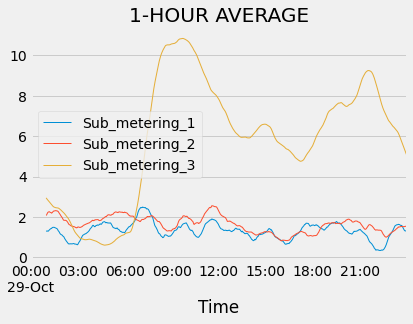

In [4]:
df.groupby(['Time']).mean().rolling(60).mean().plot(linewidth=1)
plt.title('1-HOUR AVERAGE')

Text(0.5, 1.0, '10-DAY AVERAGE')

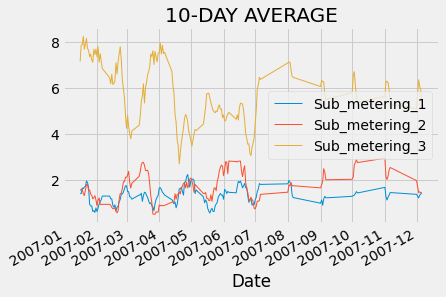

In [5]:
df.groupby(['Date']).mean().rolling(10).mean().plot(linewidth=1)
plt.title('10-DAY AVERAGE')

## PLOTTING 10-DAY AVERAGE FOR ACTIVE AND REACTIVE POWER

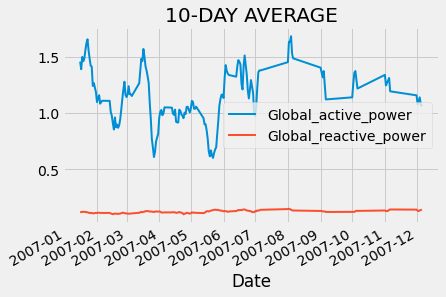

In [6]:
df['Global_active_power']=df['Global_active_power'].replace({'?':0.214})
df['Global_reactive_power']=df['Global_reactive_power'].replace({'?':0.1})
# THESE ARE THE MOST COMMONLY OCCURING VALUES IN THE FEATURE

df[['Global_reactive_power','Global_active_power']]=pd.DataFrame(np.array(df[['Global_reactive_power','Global_active_power']],dtype='float32'))
##df.groupby(['Date']).mean()[['Global_active_power','Global_reactive_power']].plot(linewidth=2)
df.groupby(['Date']).mean()[['Global_active_power','Global_reactive_power']].rolling(10).mean().plot(linewidth=2)
plt.title('10-DAY AVERAGE')
plt.show()

## PLOTTING VOLTAGE OVER DATE/TIME

Text(0, 0.5, 'Voltage')

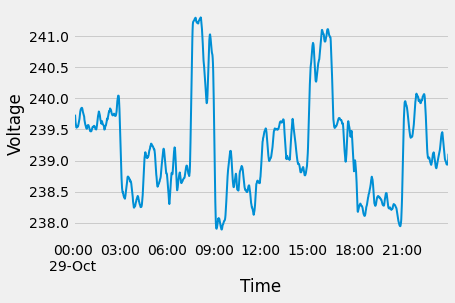

In [7]:
#df.groupby(['Voltage']).count().sort_values('Time',ascending=False)
df['Voltage']=df['Voltage'].replace({'?':240})
df['Voltage']=pd.DataFrame(np.array(df['Voltage'],dtype='float32'))
df.groupby(['Time']).mean()['Voltage'].rolling(10).mean().plot(linewidth=2)
plt.ylabel('Voltage')

Text(0, 0.5, 'Voltage')

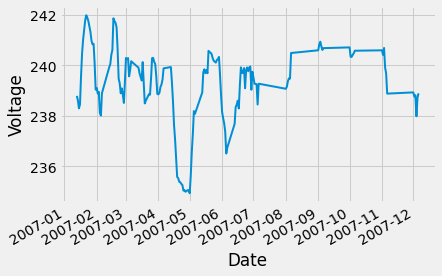

In [8]:
df.groupby(['Date']).mean()['Voltage'].rolling(7).mean().plot(linewidth=2)
plt.ylabel('Voltage')

## PLOTTING GLOBAL INTENSITY OVER TIME

Text(0, 0.5, 'Global Intensity')

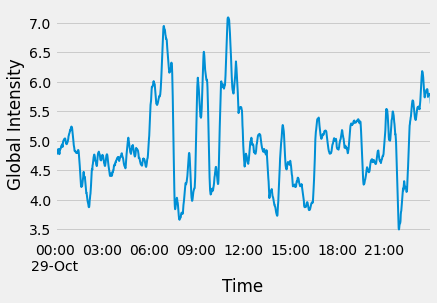

In [9]:
#df.groupby(['Global_intensity']).count().sort_values('Time',ascending=False)
df['Global_intensity']=df['Global_intensity'].replace({'?':1.4})
df['Global_intensity']=pd.DataFrame(np.array(df['Global_intensity'],dtype='float32'))
df.groupby(['Time']).mean()['Global_intensity'].rolling(10).mean().plot(linewidth=2)
plt.ylabel('Global Intensity')

Text(0.5, 1.0, 'Weekly Average')

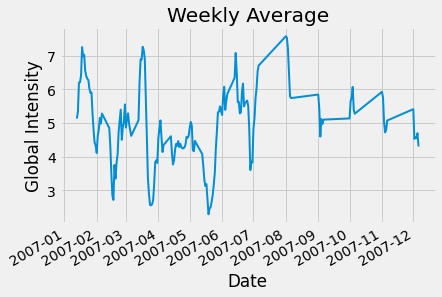

In [10]:
df.groupby(['Date']).mean()['Global_intensity'].rolling(7).mean().plot(linewidth=2)
plt.ylabel('Global Intensity')
plt.title('Weekly Average')

#### MORE IS THE POWER CONSUMPTION MORE ARE THE METER READINGS

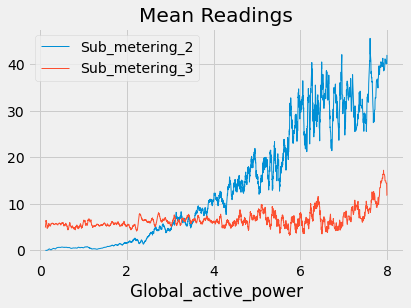

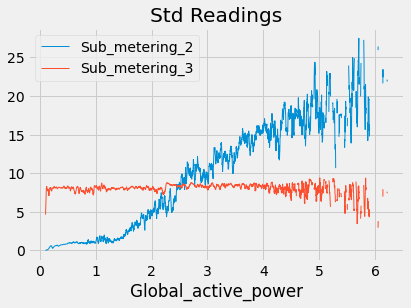

In [11]:
df.groupby(['Global_active_power']).mean()[['Sub_metering_2','Sub_metering_3']][:8].rolling(20).mean().plot(linewidth=1)
plt.title('Mean Readings')
df.groupby(['Global_active_power']).std()[['Sub_metering_2','Sub_metering_3']][:8].rolling(10).mean().plot(linewidth=1)
plt.title('Std Readings')
plt.show()

#### VARIANCE OF SUBMETERING 2 IS POSITIVELY CORRELATED WITH THE GLOBAL ACTIVE POWER

 ## MODELLING OBJECTIVES
 ##### 1. MODELLING ACTIVE AND REACTIVE POWER BY DATE
 ##### 2. MODELLING SUBMETER READINGS BY DATE
 ##### 3. MODELLING GLOBAL INTENSITY OVER TIME

In [12]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## MODELLING GLOBAL ACTIVE AND REACTIVE POWER

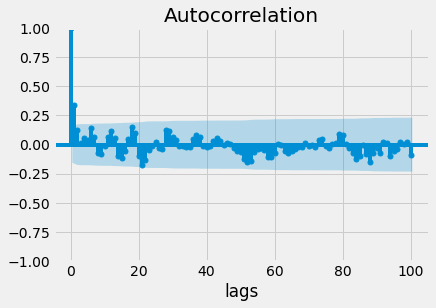

In [13]:
## PLOTTING AUTO CORRELATION AND PARTIAL CORRELATION
plot_acf(df.groupby(['Date']).mean()['Global_active_power'][:'2007-08'],lags=100,title="Global Reactive Power")
plt.xlabel('lags')
plt.title('Autocorrelation')
plt.show()

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


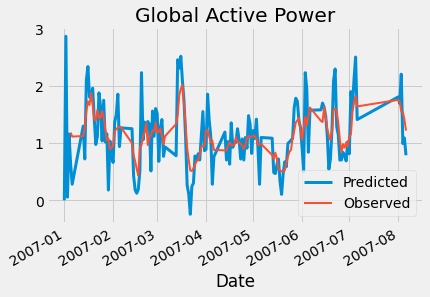

In [14]:
act_power_df=df.groupby(['Date']).mean()['Global_active_power'][:'2007-08']
model1=ARIMA(act_power_df,order=(5,2,0))
preds=model1.fit().predict()
plt.plot(preds,linewidth=3)
act_power_df.rolling(5).mean().plot(linewidth=2)
plt.legend(['Predicted','Observed'])
plt.xlabel('Date')
plt.title('Global Active Power')
plt.show()

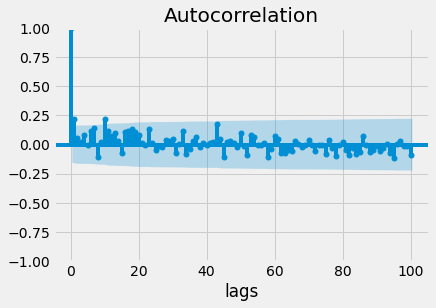

In [15]:
plot_acf(df.groupby(['Date']).mean()['Global_reactive_power'][:'2007-08'],lags=100,title="Global Reactive Power")
plt.xlabel('lags')
plt.title('Autocorrelation')
plt.show()

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


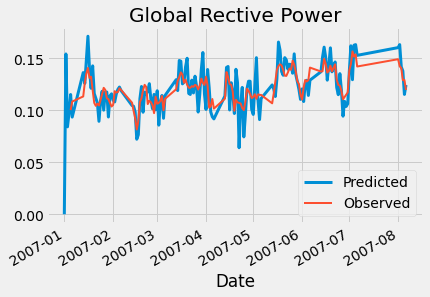

In [16]:
react_power_df=df.groupby(['Date']).mean()['Global_reactive_power'][:'2007-08']
model2=ARIMA(react_power_df,order=(10,2,0))
preds=model2.fit().predict()
plt.plot(preds,linewidth=3)
react_power_df.rolling(5).mean().plot(linewidth=2)
plt.legend(['Predicted','Observed'])
plt.xlabel('Date')
plt.title('Global Rective Power')
plt.show()

## MODELLING SUB-METERINGS

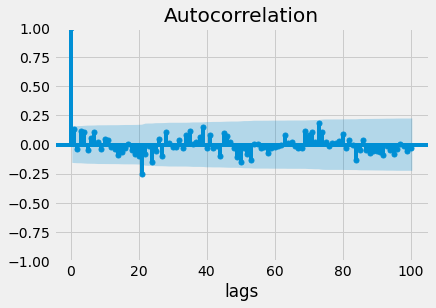

In [17]:
## PLOTTING AUTO CORRELATION AND PARTIAL CORRELATION
plot_acf(df.groupby(['Date']).mean()['Sub_metering_2'][:'2007-08'],lags=100,title='Sub_metering_2')
plt.xlabel('lags')
plt.title('Autocorrelation')
plt.show()

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


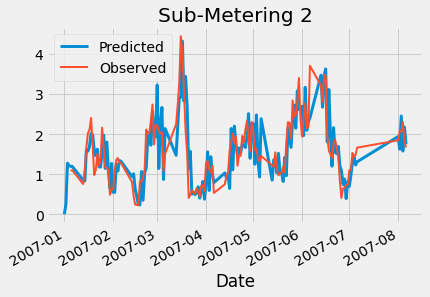

In [18]:
meter2_df=df.groupby(['Date']).mean()['Sub_metering_2'][:'2007-08']
model3=ARIMA(meter2_df,order=(5,1,0))
preds=model3.fit().predict()
plt.plot(preds,linewidth=3)
meter2_df.rolling(5).mean().plot(linewidth=2)
plt.legend(['Predicted','Observed'])
plt.xlabel('Date')
plt.title('Sub-Metering 2')
plt.show()

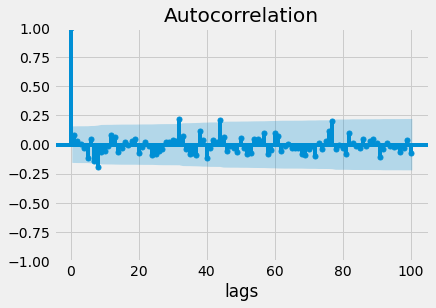

In [19]:
## PLOTTING AUTO CORRELATION AND PARTIAL CORRELATION
plot_acf(df.groupby(['Date']).mean()['Sub_metering_1'][:'2007-08'],lags=100,title='Sub_metering_1')
plt.xlabel('lags')
plt.title('Autocorrelation')
plt.show()

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


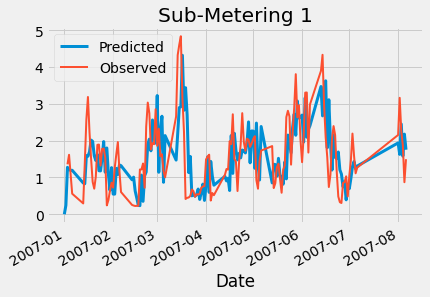

In [20]:
meter1_df=df.groupby(['Date']).mean()['Sub_metering_2'][:'2007-08']
model4=ARIMA(meter2_df,order=(5,1,0))
preds=model4.fit().predict()
plt.plot(preds,linewidth=3)
meter1_df.rolling(3).mean().plot(linewidth=2)
plt.legend(['Predicted','Observed'])
plt.xlabel('Date')
plt.title('Sub-Metering 1')
plt.show()

## MODELLING GLOBAL INTENSITY

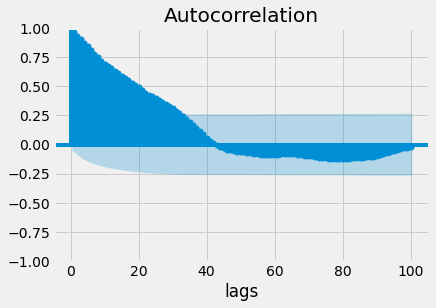

In [21]:
plot_acf(df.groupby(['Time']).mean()['Global_intensity'],lags=100,title="Global Reactive Power")
plt.xlabel('lags')
plt.title('Autocorrelation')
plt.show()

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  self._init_dates(dates, freq)


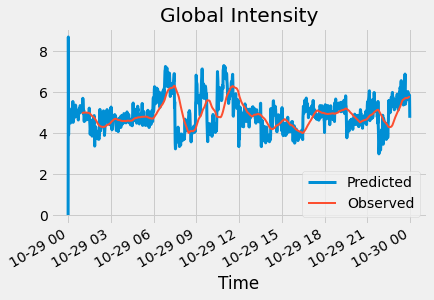

In [22]:
int_df=df.groupby(['Time']).mean()['Global_intensity']
model5=ARIMA(int_df,order=(5,3,0))
preds=model5.fit().predict()
plt.plot(preds,linewidth=3)
int_df.rolling(60).mean().plot(linewidth=2)
plt.legend(['Predicted','Observed'])
plt.xlabel('Time')
plt.title('Global Intensity')
plt.show()